# Import dependencies

In [1]:
from comet_ml import Experiment

In [2]:
%matplotlib inline

In [3]:
import os
import warnings
import glob

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
    array_to_img,
)

Using TensorFlow backend.


In [5]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras import callbacks
from keras.callbacks import EarlyStopping

import numpy as np
from IPython.display import Image

# Main variables

In [6]:
DATA_DIR = "dataset"
MODELS_DIR = "models"

In [7]:
params = {}


params["batch_size"] = 64
params["num_classes"] = 2
params["epochs"] = 10
params["optimizer"] = "adam"
params["activation"] = "relu"
params["base_lr"] = 0.0001
params["fine_tune_lr"] = params["base_lr"]/10
params["fine_tuning"] = False
params["fine_tune_at"] = 20
params["initial_epochs"] = 15
params["fine_tune_epochs"] = 15

# Review the data

In [8]:
img_list = glob.glob(os.path.join(DATA_DIR,"*/*/*.jpg"))
print(len(img_list))

22263


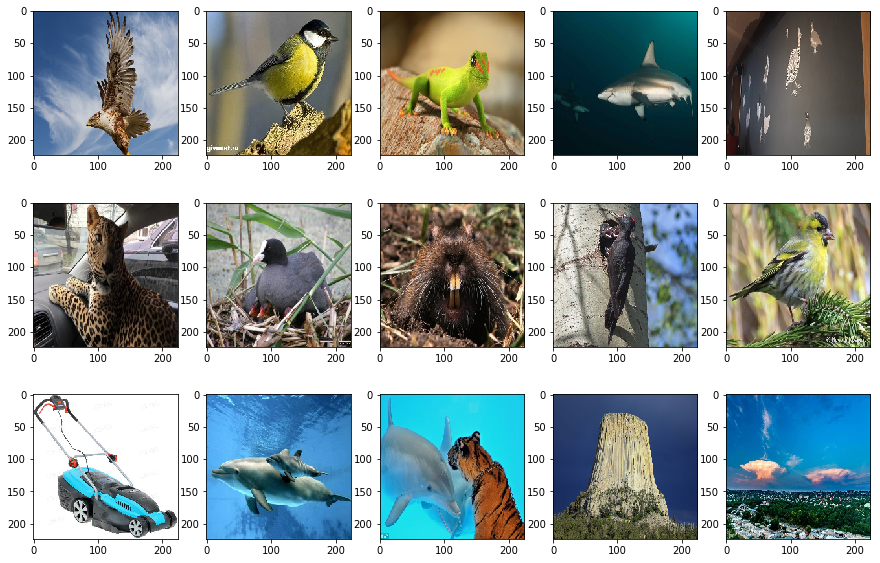

In [9]:
fig = plt.gcf()
fig.set_size_inches(15,10)
for i, img_path in enumerate(random.sample(img_list, 15)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)

    plt.subplot(3, 5, i + 1)
    plt.imshow(img.squeeze())

# Define the network

In [10]:
def get_model(params):
    base_model = MobileNet(
        weights="imagenet", include_top=False
    )  # imports the mobilenet model and discards the last 1000 neuron layer.

    for layer in base_model.layers:
        layer.trainable = params["fine_tuning"]
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation=params["activation"])(
        x
    )  # we add dense layers so that the model can learn more complex functions and classify for better results.
    x = Dense(1024, activation=params["activation"])(x)  # dense layer 2
    x = Dense(512, activation=params["activation"])(x)  # dense layer 3
    
    preds = Dense(1,activation='sigmoid')(
        x
    )  # final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=preds)


    return model

def fine_tune_model(model, params):
    
    for layer in model.layers:
        layer.trainable = params["fine_tuning"]
    
    # or if we want to set the first 20 layers of the network to be non-trainable
    for layer in model.layers[:params["fine_tune_at"]]:
        layer.trainable = False
    for layer in model.layers[params["fine_tune_at"]:]:
        layer.trainable = True
    
    return model

model = get_model(params)

Instructions for updating:
Colocations handled automatically by placer.


/home/gaiar/miniconda3/envs/birds/lib/python3.6/site-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [12]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)  # included in our dependencies

valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255, 
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=params["batch_size"],
    class_mode="binary",
    shuffle=True,
)

validation_generator = valid_datagen.flow_from_directory(
    DATA_DIR + "/valid",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=params["batch_size"],
    class_mode="binary",
    shuffle=True,
)

Found 17778 images belonging to 2 classes.
Found 4489 images belonging to 2 classes.


In [13]:
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

In [14]:
adam = keras.optimizers.Adam(lr=params["base_lr"])


model.compile(
    optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"]
)

experiment = Experiment(project_name="bird-vs-not-bird",api_key="vXmIzDFObhyfUYzH4JUg8rOQp")

# log parameters in Comet.ml
experiment.log_parameters(params)

COMET INFO: old comet version (1.0.51) detected. current: 1.0.52 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/gaiar/bird-vs-not-bird/e91734ade2e6464488413bd657529d39



# Setup callbacks 

In [15]:
log = callbacks.CSVLogger(os.path.join(MODELS_DIR, "bird-vs-not-bird-log.csv"))

checkpoint = callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "bird-vs-not-bird-weights-{epoch:02d}.h5"),
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

lr_decay = callbacks.LearningRateScheduler(
    schedule=lambda epoch: params["base_lr"] * (0.9 ** epoch)
)

early_stopping = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=5, verbose=1, mode="auto"
)

# Train the model

In [16]:
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

In [ ]:
with experiment.train():
    step_size_train = train_generator.samples // params["batch_size"]
    history = model.fit_generator(
        generator=train_generator,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // params["batch_size"],
        steps_per_epoch=step_size_train,
        epochs=params["epochs"],
        verbose=1,
        callbacks=[log, checkpoint, lr_decay],
        use_multiprocessing=True,
        workers=7,
        max_queue_size = 2000
    )

model.save_weights(os.path.join(MODELS_DIR, "mobilenet.bird-vs-not-bird.generic.h5"))

#experiment.end()

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
269/277 [============================>.] - ETA: 7s - loss: 0.2013 - acc: 0.9216

# Review the results of initial model

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,10)


acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# Fine-tuning the model

In [ ]:
params["fine_tuning"] = True


model = fine_tune_model(model, params)

experiment.log_parameters(params)


In [ ]:
adam = keras.optimizers.Adam(lr=params["fine_tune_lr"])

model.compile(
    optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"]
)

model.summary()

In [ ]:
total_epochs = params["initial_epochs"] + params["fine_tune_epochs"]



with experiment.train():
    step_size_train = train_generator.samples // params["batch_size"]
    history_fine = model.fit_generator(
        generator=train_generator,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // params["batch_size"],
        steps_per_epoch=step_size_train,
        initial_epoch = params["initial_epochs"],
        epochs=total_epochs,
        verbose=1,
        callbacks=[log, checkpoint, lr_decay],
        use_multiprocessing=True,
        workers=7,
    )

model.save_weights(os.path.join(MODELS_DIR, "mobilenet.bird-vs-not-bird.fine-tune.h5"))

experiment.end()

# Review the results of fine-tuned model

In [ ]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()